In [3]:
import pandas as pd

df = pd.read_csv('SF_case_data.csv')
df.head(10)

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads
5,2020-01-01,app_start,NaN,android,5148476,male,Saint-Petersburg,-
6,2020-01-01,app_start,NaN,android,8383386,female,Saint-Petersburg,vk_ads
7,2020-01-01,app_start,NaN,android,8581267,female,Saint-Petersburg,google_ads
8,2020-01-01,app_start,NaN,ios,10144701,female,Moscow,-
9,2020-01-01,app_start,NaN,ios,10274354,female,Saint-Petersburg,instagram_ads


In [4]:
bydate = df.groupby('date').count().event


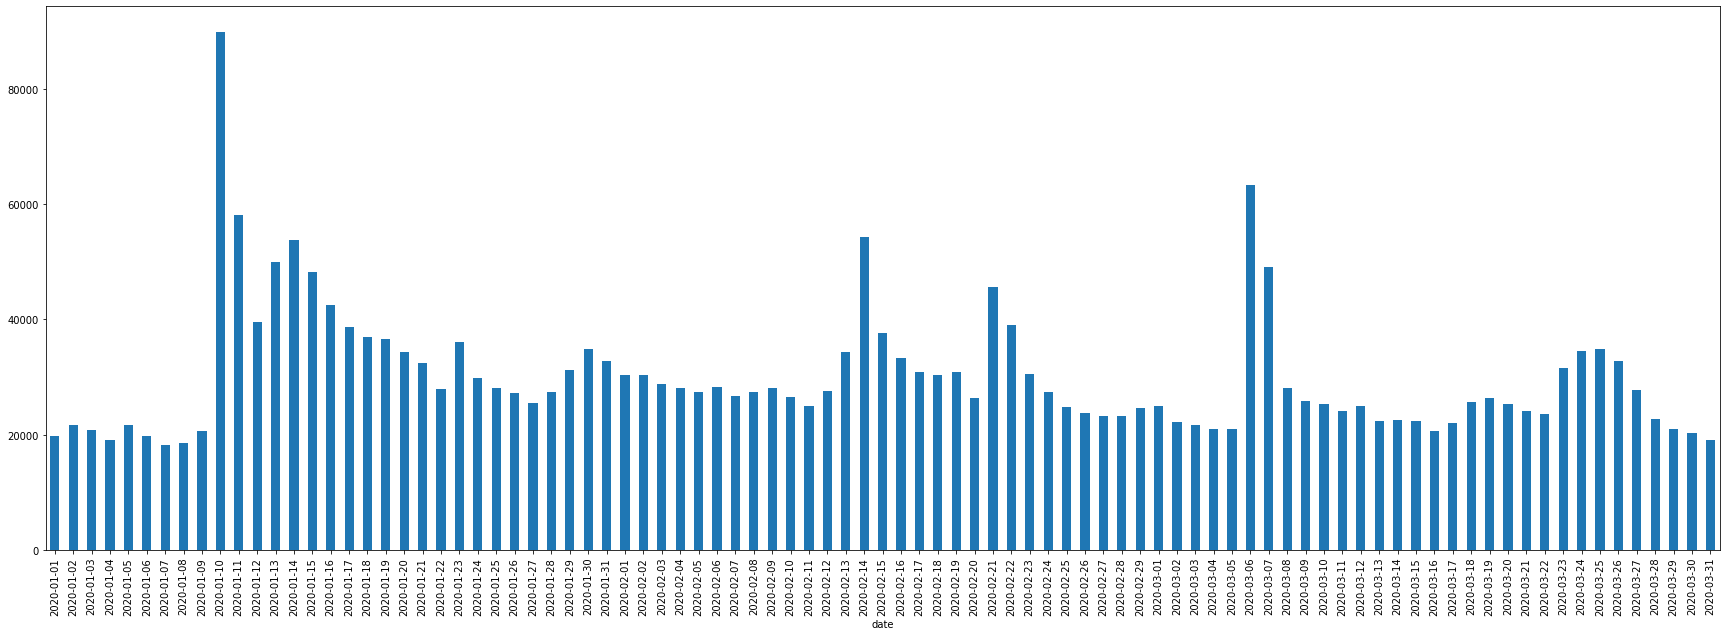

In [5]:
bydate.plot(kind='bar', figsize=[30, 10])

In [6]:
df.event.unique()

array(['app_start', 'choose_item', 'purchase', 'search', 'tap_basket',
       'app_install', 'register'], dtype=object)

In [7]:
len(df[
    (df.date == '2020-03-31') 
    & (df.event == 'app_install')
].device_id.unique())

968

In [8]:
import numpy as np
installed = df[(df.event == 'app_install')][['device_id', 'date']].groupby('device_id').agg({
    'date': np.min
}).reset_index()
installed.rename(columns={'date': 'mindate'}, inplace=True)
installed.head(1)

,device_id,mindate
0,4013,2020-01-15


In [9]:
filtered = df[
    (df.date == '2020-02-14') 
    & (df.event == 'app_start')
].copy()


In [10]:
joined = pd.merge(filtered, installed, left_on='device_id', right_on='device_id')

In [11]:
allC = len(joined.device_id.unique())
beforeC = len(joined[(joined.date > joined.mindate)].device_id.unique())
print(beforeC*100/allC)

64.38169756761354


In [12]:
data = pd.read_csv('SF_case_data.csv')

In [13]:
installs = data[data['event'] == 'app_install']
data['install_date'] = data['device_id'].map(installs.set_index('device_id')['date'])
def new_column(date1,date2,value):
    if date1 == date2:
        return value
data['install_group'] = data.apply(lambda x: new_column(date1 = x['date'], date2 = x['install_date'], value = 'Установили в этот же день'), axis=1)
data['install_group'] = data['install_group'].fillna('Остальные')
data[data['event'] == 'app_start']['install_group'].value_counts()

Остальные                    594108
Установили в этот же день    154597
Name: install_group, dtype: int64

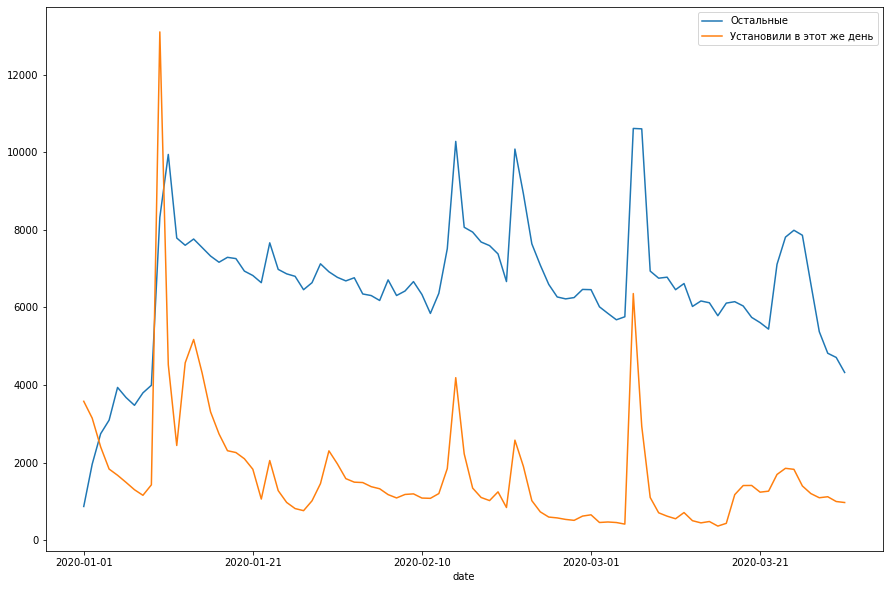

In [14]:
df1 = data[data['event'] == 'app_start'].groupby(['date','install_group']).size().reset_index(name = 'users')
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=[15, 10])

for key, grp in df1.groupby(['install_group']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='users', label=key)

plt.legend(loc='best')
plt.show()

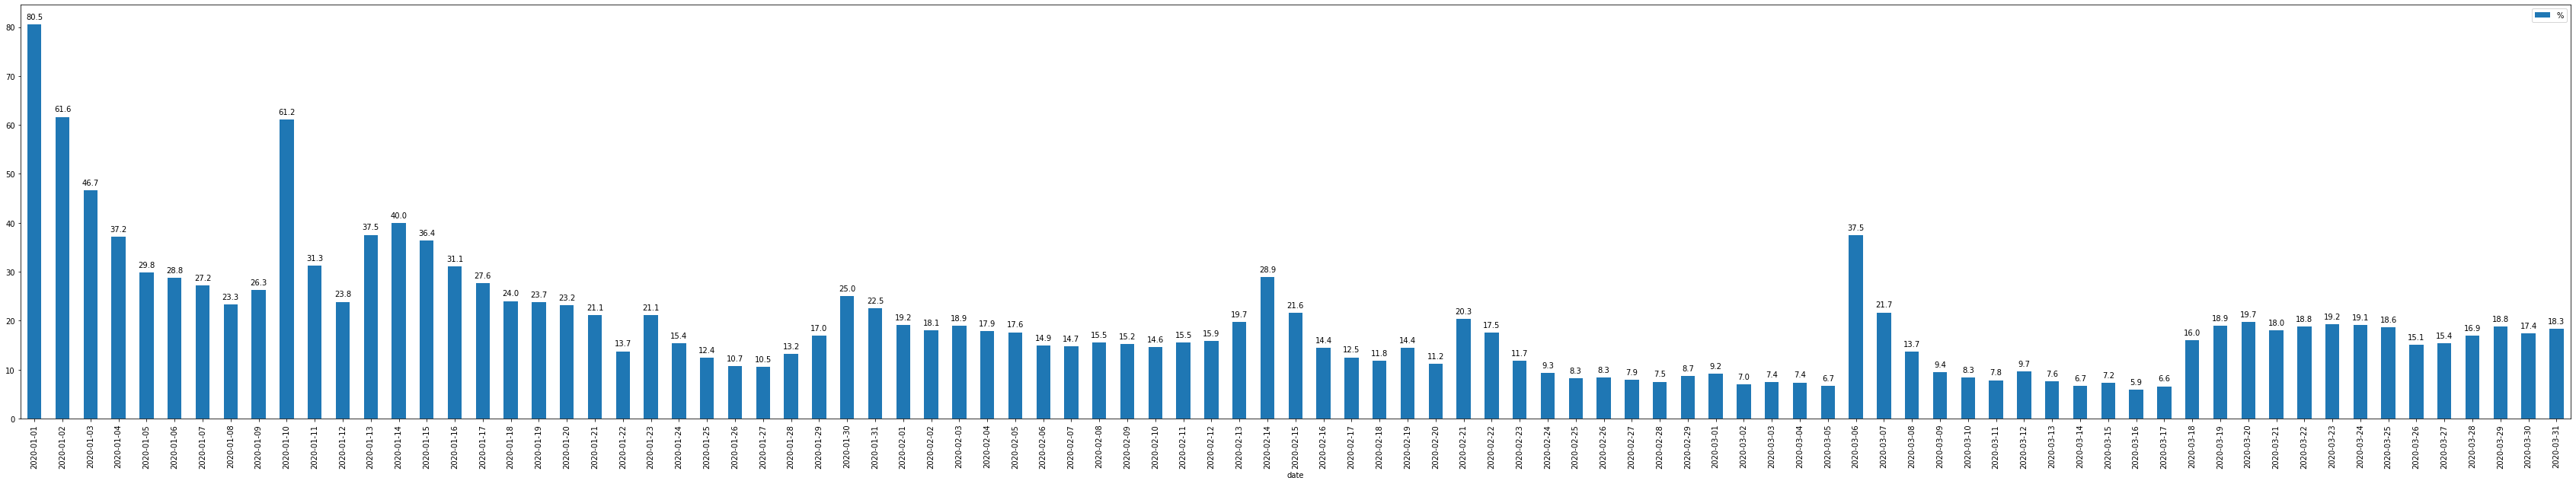

In [15]:
df1 = data[data['event'] == 'app_start'].groupby(['date','install_group']).size().reset_index(name = 'users')
groupped_data = df1.groupby(['date']).agg({'users': 'sum'}).reset_index()
groupped_data
joined = pd.merge(df1, groupped_data, left_on = 'date', right_on = 'date')
joined['%'] = joined.apply(lambda x: x['users_x']*100/x['users_y'], axis=1)
ax = joined[(joined.install_group == 'Установили в этот же день')].plot(kind='bar', x='date', y='%', figsize=[60, 10])
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)

In [16]:
df1

,date,install_group,users
0,2020-01-01,Остальные,866
1,2020-01-01,Установили в этот же день,3579
2,2020-01-02,Остальные,1957
3,2020-01-02,Установили в этот же день,3144
4,2020-01-03,Остальные,2742
...,...,...,...
177,2020-03-29,Установили в этот же день,1117
178,2020-03-30,Остальные,4710
179,2020-03-30,Установили в этот же день,994
180,2020-03-31,Остальные,4322


In [17]:
df = data[data['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id').groupby(['date','utm_source']).size().reset_index(name = 'users')
pd.pivot_table(df, values='users', index='utm_source', aggfunc='sum').sort_values('users',ascending = False)
df['channel'] = 'channel'
pd.crosstab(df.utm_source, df.channel, values=df.users, aggfunc=np.sum, normalize='columns').sort_values('channel', ascending = False)

channel,channel
utm_source,
-,0.217179
yandex-direct,0.180429
google_ads,0.164692
vk_ads,0.146188
instagram_ads,0.130016
facebook_ads,0.098720
referal,0.062776


In [56]:
data = pd.read_csv('SF_case_data.csv')


In [57]:
first_registration = data[data['event'] == 'register'].sort_values('date').drop_duplicates('device_id')
first_registration['finally_registered'] = 1
data['first_registration'] = data['device_id'].map(first_registration.set_index('device_id')['date'])
data['finally_registered'] = data['device_id'].map(first_registration.set_index('device_id')['finally_registered'])
already_reg = data[data['first_registration'] < data['date']]
already_reg['registered'] = 1
requires_reg1 = data[(data['first_registration'].isna() == True)]
requires_reg1['registered'] = 0
requires_reg2 =  data[data['first_registration'] >= data['date']]
requires_reg2['registered'] = 0
data = pd.concat([already_reg,requires_reg1,requires_reg2])
data[data['event'] == 'tap_basket'].groupby('registered').count()

<ipython-input-57-39cbdd3bfc77>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  already_reg['registered'] = 1
<ipython-input-57-39cbdd3bfc77>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  requires_reg1['registered'] = 0
<ipython-input-57-39cbdd3bfc77>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,first_registration,finally_registered
registered,,,,,,,,,,
0,160409,160409,0,160409,160409,160409,160409,160409,105031,105031
1,217256,217256,0,217256,217256,217256,217256,217256,217256,217256


In [55]:
not_reg = data[data['registered'] == 0]
funnel_not_reg = pd.crosstab(not_reg.utm_source, not_reg.event, values=not_reg.device_id, aggfunc=pd.Series.nunique)
funnel_not_reg['1 step'] = funnel_not_reg['search']*100/funnel_not_reg['app_start']
funnel_not_reg['2 step'] = funnel_not_reg['choose_item']*100/funnel_not_reg['search']
funnel_not_reg['3 step'] = funnel_not_reg['tap_basket']*100/funnel_not_reg['choose_item']
funnel_not_reg['4 step'] = funnel_not_reg['register']*100/funnel_not_reg['tap_basket']
funnel_not_reg['5 step'] = funnel_not_reg['purchase']*100/funnel_not_reg['register']
funnel_not_reg

event,app_install,app_start,choose_item,purchase,register,search,tap_basket,1 step,2 step,3 step,4 step,5 step
utm_source,,,,,,,,,,,,
-,32460,48670,38026,14073,16527,46742,29223,96.038627,81.352959,76.850050,56.554769,85.151570
facebook_ads,13916,23780,18713,7506,8672,22822,14592,95.971405,81.995443,77.977876,59.429825,86.554428
google_ads,26286,35778,27416,9777,11405,34217,20765,95.636984,80.123915,75.740444,54.924151,85.725559
instagram_ads,20096,29237,22858,9394,10750,28017,17881,95.827205,81.586180,78.226442,60.119680,87.386047
referal,9282,14866,11880,5503,6193,14316,9518,96.300283,82.984074,80.117845,65.066190,88.858389
vk_ads,23189,32353,25422,10919,12421,31010,20014,95.848917,81.980006,78.727087,62.061557,87.907576
yandex-direct,29368,38578,29591,10581,12342,36933,22417,95.735912,80.120759,75.756142,55.056430,85.731648


In [1]:
reg = data[data['registered'] == 1]
funnel_reg = pd.crosstab(reg.utm_source, reg.event, values=reg.device_id, aggfunc=pd.Series.nunique)
funnel_reg['1 step'] = funnel_reg['search']*100/funnel_reg['app_start']
funnel_reg['2 step'] = funnel_reg['choose_item']*100/funnel_reg['search']
funnel_reg['3 step'] = funnel_reg['tap_basket']*100/funnel_reg['choose_item']
funnel_reg['5 step'] = funnel_reg['purchase']*100/funnel_reg['tap_basket']
funnel_reg


NameError: name 'data' is not defined

In [2]:
data = pd.read_csv('SF_case_data.csv')


NameError: name 'pd' is not defined

In [84]:
import numpy as np

purchased = data[(data.event == 'purchase')][['device_id', 'date']].groupby('device_id').agg({
    'date': np.min
}).reset_index()
purchased.rename(columns={'date': 'mindate'}, inplace=True)
purchased.head(1)

filtered = data[(data.event == 'purchase')].copy()

In [85]:
joined = pd.merge(filtered, installed, left_on='device_id', right_on='device_id')
grouped = joined[(joined.mindate == joined.date)].groupby('utm_source').agg({"purchase_sum": "sum", "device_id": "nunique"})
grouped

,purchase_sum,device_id
utm_source,,
-,5511400.5,7756
facebook_ads,2237399.5,3400
google_ads,4570341.0,6412
instagram_ads,3346402.0,4734
referal,1565734.0,2233
vk_ads,4057710.5,5744
yandex-direct,5186573.5,7043


In [66]:
data = pd.read_csv('SF_case_data.csv')
data = data[(data.date < '2020-04-01')]

In [67]:
filtered = data[(data.event == 'purchase')].copy()

In [82]:
filtered.groupby('utm_source').agg({"purchase_sum": "sum", "device_id": "nunique"}).reset_index().sort_values('purchase_sum', ascending=False)

,utm_source,purchase_sum,device_id
0,-,21449749.5,16598
5,vk_ads,16389652.5,12364
3,instagram_ads,14546969.0,10762
6,yandex-direct,13915368.0,12028
2,google_ads,12868276.0,11339
1,facebook_ads,12249901.0,9017
4,referal,8837044.5,6362


In [86]:
#2233*200
#
#Яндекс	10 491 707 руб.
#Гугл	10 534 878 руб.
#Фейсбук	8 590 498 руб.
#Инстаграм	8 561626 руб.
#ВК	9 553 531 руб.

446600

In [13]:
import pandas as pd
l = [
    ['Реферальная программа', 8837044 - 2233*200],
    ['Яндекс', 13915368.0 - 10491707], 
    ['Гугл', 12868276.0 - 10534878], 
    ['Фейсбук', 12249901.0 - 8590498], 
    ['Инстаграмм', 14546969.0 - 8561626], 
    ['ВК', 16389652.5 - 9553531], 
]

f = pd.DataFrame(l, columns=['Канал', 'ROMI'])
f.index.name = 'id'
f.sort_values('ROMI', ascending=False)
f.to_csv('romi.csv')

In [ ]:
8390444
3423661.0
2333398.0
3659403.0
5985343.0
6836121.5